# 3. 有意性の推定

測定された散乱事象数は測定に対してどの程度一致したでしょうか？ラザフォード散乱があることを再発見するためには、なるべく大角度での散乱事象を観測することが望ましいです。測定回数は散乱事象を観測したと宣言するのに十分でしょうか。

信号事象の有意性を議論するためには、観測された事象数Nが「背景事象数bと誤差σの仮定のみで観測される確率」を計算します。**背景事象だけで実際に観測された事象数が説明できてしまう確率が十分小さい**ことを示すことで、信号が有意であることを示します。推定信号事象数sが事前にわかっている際は、N=s+bとすることで事前に推定値を計算することもできます。

ここでは確率分布が正規分布であると仮定して、有意性を

$$
Z=\frac{n-b}{\sqrt{b+\sigma^2}}
$$

を用いて計算します[<sup>1</sup>](#id_01)。sを用いる場合は

$$
Z=\frac{s}{\sqrt{b+\sigma^2}}
$$
とすればおおよその値を計算できます。

<span id="id_01">[1]確率分布がbを中心とした幅$b+\sigma^2$のガウシアンと仮定すると得られる。背景事象が十分にない場合はガウシアンでなくポアソン分布を仮定する必要があり、より複雑な式で計算する必要がある。</span>

# 3.0. 初期設定・測定データの確認

まずは3.0.1.でこの有意性の式を含めた関数を定義します。また、有意性は1σ, 2σなどと表しますが、これを具体的な確率に計算しなおす関数も定義します。前回の情報は3.0.3.を編集することで取り込めますし、このノートブックから必要なセルを前回のノートブックにコピーしてもよいです。

In [38]:
# @title 3.0.1. 必要設定の読み込み

#スクリプト実行に必要なパッケージ。
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from scipy.stats import poisson,norm
from scipy import integrate

#用いる関数を定義
def sig(x, a, m, s):#ガウシアン
    if a<0 or s<0:
        return 1e99
    return a*np.exp(-0.5*(x-m)**2/s**2)

def bg(x, b, beta):#exponential
    return b*np.exp(-x/beta)

def bgFull(x, a, m, s, b, beta):
    return sig(x,a,m,s)+bg(x,b,beta)

def sigFull(x, a, m, s, b, beta, scale,a2,m2,s2):
    return scale*bgFull(x,a,m,s,b,beta)+sig(x,a2,m2,s2)


def lin(x,a,b):
    return a*x+b

def dlin(x,a,b,dx,da,db):#直線フィッティングの誤差導出用関数
    dy=(x*da)**2
    dy+=(dx*a)**2
    dy+=db**2
    dy=np.sqrt(dy)
    #print("{:10.4f}, {:10.4f}, {:10.4f}".format((x*da),dx*a,db))
    return dy
def pathToTime(path):
    time_format='"%Y-%m-%d" "%H:%M:%S"'
    temp = np.genfromtxt(path, skip_header=1025,skip_footer=1,dtype=str)
    start_text=temp[0]+' '+temp[1]
    start_time=datetime.datetime.strptime(start_text, time_format)
    end_text=temp[2]+' '+temp[3]
    end_time=datetime.datetime.strptime(end_text, time_format)
    Time=(end_time-start_time).seconds
    return Time

def significance(n, b, sigma): #有意性を返す式
    return (n-b)/np.sqrt(b+sigma**2)

def prob(Z):#有意性を「観測した事象より大きく予想から外れる確率」に解釈しなおす式
    return 1-(norm.cdf(Z)-norm.cdf(-Z))

def rebin(x,y,ndiv=3):
    bins = len(x)-1
    # ndiv
    print(len(x),x[-1],ndiv,bins%ndiv)
    if bins%ndiv != 0:
      return rebin(x[:-1],y[:-1],ndiv)
    bins_new = int(bins/ndiv)
    print(bins_new)
    dx=x[1]-x[0]
    x_new = np.linspace(x[0],x[-1], bins_new+1)
    y_new = np.array([np.sum(y[i*ndiv:(i+1)*ndiv]) for i in range(bins_new+1)])
    print(len(x_new),x_new[-1])
    return x_new, y_new

#使用例
n=110
dn=4.3
b=50
sigma=np.sqrt(dn**2+b)
print("背景事象数 {:.2f} +/- {:.2f} と推測されるとき、{:d}回より大きく予想が外れる確率{:.2f}σ={:.2e}%".format(b,sigma,n,significance(n,b,sigma),prob(significance(n,b,sigma))*100))
print("信号事象発見に必要な有意性5σ={:.2e}%".format(prob(5)*100))
print("3σ={:.2e}%".format(prob(3)*100))
print("2σ={:.2e}%".format(prob(2)*100))
print("1σ={:.2e}%".format(prob(1)*100))

背景事象数 50.00 +/- 8.28 と推測されるとき、110回より大きく予想が外れる確率5.51σ=3.55e-06%
信号事象発見に必要な有意性5σ=5.73e-05%
3σ=2.70e-01%
2σ=4.55e+00%
1σ=3.17e+01%


In [2]:
# @title 3.0.2. Googleドライブのマウント(オプション)

#実験データなど、Googleドライブにあるファイルにアクセスしたい場合に実行する。自分のアカウントで要認証。ダミーデータで取り組む場合は実行不要
from google.colab import drive
drive.mount('/content/drive')

#ファイルを格納するディレクトリを指定、要編集
basePath='/content/drive/MyDrive/temp/b3exp/'

Mounted at /content/drive


In [9]:
# @title 3.0.3. 必要な情報の引継ぎ

#パスと名前を書き換える
#パルス情報
pulse_file_list=[]
pulse_file_list.append(['pulse2p4.csv',2.4])
pulse_file_list.append(['pulse2p2.csv',2.2])
pulse_file_list.append(['pulse2p0.csv',2.0])
pulse_file_list.append(['pulse1p8.csv',1.8])
pulse_file_list.append(['pulse1p6.csv',1.6])
pulse_file_list.append(['pulse1p4.csv',1.4])
#強度測定
calib_file='60sec0degNoTarget.csv'
#厚さ測定
Aldeg0 = np.genfromtxt(basePath+'60sec0degAl.csv', skip_footer=6)
Audeg0 = np.genfromtxt(basePath+'Au.csv', skip_footer=6)
#測定パラメタ
theta=20
tmes=300#sec, 測定時間

#以下書き換え不要

pulse_list=np.empty((0,1024),int)
hight=[]
for file_i in pulse_file_list:#入力したデータ数分繰り返し
    y=np.genfromtxt(basePath+file_i[0], skip_footer=6)#1ヒストグラム取り出し
    y=[y]
    pulse_list=np.append(pulse_list,y,axis=0)
    hight=np.append(hight,file_i[1])
ch = []
dch = []
x=np.arange(0,1024)#x軸
dA=10
for hight_i,pulse_i in zip(hight,pulse_list):#入力したデータ数分繰り返し
    y=pulse_i
    dy=np.where(y > 0, np.sqrt(y), 1.0)#誤差は統計誤差の√nのみ,nが0なら0
    par_gaus, cov_gaus = curve_fit(sig, x, y, p0=(np.max(y), np.argmax(y), dA),sigma=dy)#適切な初期値を与えてフィッティング
    perr_gaus = np.sqrt(np.diag(cov_gaus))#分散共分散行列の対角成分取り出し=分散の取り出し
    #結果を記録
    ch=np.append(ch,float(par_gaus[1]))
    dch=np.append(dch,float(perr_gaus[1]))
par_line, cov_line = curve_fit(lin, ch, hight, sigma=dch)#f(ch+/-dch)=Eを直線(lin)でフィッティング
perr_line = np.sqrt(np.diag(cov_line))#誤差抽出
#強度測定
alpha_calib =np.genfromtxt(basePath+calib_file, skip_footer=6)
Tcalib=pathToTime(basePath+calib_file)
dy=np.where(alpha_calib > 0, np.sqrt(alpha_calib), 1.0)#誤差は統計誤差の√nのみ,nが0なら0
par_calib, cov_calib = curve_fit(sig, x, alpha_calib, p0=(100, 800, 25), sigma=dy)#適切な初期値を与えてフィッティング
perr_calib = np.sqrt(np.diag(cov_calib))#分散共分散行列の対角成分取り出し=分散の取り出し
scaling=par_line[0]*par_calib[1] + par_line[1]
par_line, cov_line = curve_fit(lin, ch, hight/scaling*4.5, sigma=dch)#f(ch+/-dch)=Eを直線(lin)で再フィッティング
perr_line = np.sqrt(np.diag(cov_line))#誤差抽出
#Alに関する変換
dy=np.where(Aldeg0 > 0, np.sqrt(Aldeg0), 1.0)
par_Al, cov_Al = curve_fit(sig, x, Aldeg0, p0=(np.max(Aldeg0), np.argmax(Aldeg0), 30), sigma=dy)
perr_Al = np.sqrt(np.diag(cov_Al))
EAlreco=lin(par_Al[1],par_line[0],par_line[1])
dEAlreco=dlin(par_Al[1],par_line[0],par_line[1],perr_Al[1],perr_line[0],perr_line[1])
#Auに関する変換
dy=np.where(Audeg0 > 0, np.sqrt(Audeg0), 1.0)
par_Au, cov_Au = curve_fit(sig, x, Audeg0, p0=(np.max(Audeg0), np.argmax(Audeg0), 25), sigma=dy)
perr_Au = np.sqrt(np.diag(cov_Au))
EAureco=lin(par_Au[1],par_line[0],par_line[1])
dEAureco=dlin(par_Au[1],par_line[0],par_line[1],perr_Au[1],perr_line[0],perr_line[1])

Ealphatheo=[1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.1, 4.5]#アルファ線のエネルギー
EAltheo=[5.017, 6.804, 8.777, 10.944, 13.308, 15.867, 16.402, 18.618]#Al中の飛程
EAutheo=[2.699, 3.435, 4.230, 5.086, 6.002, 6.974, 7.175, 8.001]#Au中の飛程
par_Al_line, cov_Al_line = curve_fit(lin, Ealphatheo, EAltheo)#アルファ線のエネルギー[MeV]->アルファ線が飛べるAlの厚さ[um]の式をフィッティング
perr_Al_line = np.sqrt(np.diag(cov_Al_line))
par_Au_line, cov_Au_line = curve_fit(lin, Ealphatheo, EAutheo)#アルファ線のエネルギー[MeV]->アルファ線が飛べるAlの厚さ[um]の式をフィッティング
perr_Au_line = np.sqrt(np.diag(cov_Au_line))
RAl=lin(EAlreco,par_Al_line[0],par_Al_line[1])#測定された、残りのエネルギーで飛べるAlの厚さ
dRAl=dlin(EAlreco,par_Al_line[0],par_Al_line[1],dEAlreco,perr_Al_line[0],perr_Al_line[1])#その誤差
dxAl=18.618-RAl#アルファ線が飛んできたAlの厚さ
RAu=lin(EAureco,par_Au_line[0],par_Au_line[1])
dRAu=dlin(EAureco,par_Au_line[0],par_Au_line[1],dEAureco,perr_Au_line[0],perr_Au_line[1])
dxAu=8.001-RAu



#計算
dr2=6/2 #mm センサー手前のウィンドウ幅
S2=np.pi*dr2**2 #センサー手前のウィンドウ面積
L=130 #mm 線源からセンサーまでの距離
dOmega_RtoS=S2/L**2 #線源からセンサーまでの見込み角
dr1=6/2 #mm ターゲット手前のウィンドウ幅
S1=np.pi*dr1**2 #センサー手前のウィンドウ面積
L1=58.3 #mm 線源からターゲット手前のウィンドウまでの距離
dOmega_RtoT=S1/L1**2 #線源からターゲットの見込み角
#オプション課題：ターゲット手前のウィンドウの傾きを考慮するとどうなるか検討する
L3=60 #mm ターゲットから線源までの距離
dOmega_TtoS=S2/L3**2 #ターゲットから線源までの見込み角
#強度測定
Ncalib=np.sum(alpha_calib)#キャリブレーションのデータ測定で得られたイベント数を全て足す
B0=Ncalib/Tcalib*4*np.pi/dOmega_RtoS#線源強度
dB0=np.sqrt(Ncalib)/Tcalib*4*np.pi/dOmega_RtoS#統計誤差
B=B0*dOmega_RtoT/4/np.pi
dB=dB0*dOmega_RtoT/4/np.pi
NA=6.02e23
Al_weight=26.98
Au_weight=196.97
NAl=dxAl*1e-4*2.69*NA/Al_weight #dxAl[cm]*2.69[g/cm^3]*NA[count/mol]/weight[g/mol]
dNAl=dRAl*1e-4*2.69*NA/Al_weight
NAu=dxAu*1e-4*19.3*NA/Au_weight
dNAu=dRAu*1e-4*19.3*NA/Au_weight
z = 2  # alpha は4He 2+
ZAl = 13  # Alの陽子数は13
ZAu = 79  # Auの陽子数は79
hbarc = 197.3
alpha = 1/137.
e2 = hbarc*alpha
E = 4.5
AAl = (z*ZAl*e2/4/E)**2
dsigmadOmegaAl=AAl*(np.sin(np.radians(theta)/2))**-4
AAu = (z*ZAu*e2/4/E)**2
dsigmadOmegaAu=AAu*(np.sin(np.radians(theta)/2))**-4
N_expectedAl=B*tmes*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS
dN_expectedAl=B*tmes*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAl)**2)+(dNAl/NAl)**2)
N_expectedAu=B*tmes*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS
dN_expectedAu=B*tmes*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS*np.sqrt((dB/B)**2+(1/np.sqrt(NAu)**2)+(dNAu/NAu)**2)



print("ターゲットに入射する信号強度={:6.1f} +/- {:6.1f} [Bq]".format(B,dB))
print("ターゲットから線源までの見込み角={:10.3e} [sr]".format(dOmega_TtoS))
print("Al厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAl,dRAl))
print("Au厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAu,dRAu))
print("キャリブレーションを行った時間={:4.0f}[sec]".format(Tcalib))
print("推定測定回数(Al)={:10.1e}+/-{:10.1e}".format(N_expectedAl,dN_expectedAl))
print("推定測定回数(Au)={:10.1e}+/-{:10.1e}".format(N_expectedAu,dN_expectedAu))

ターゲットに入射する信号強度=1135.0 +/-    9.5 [Bq]
ターゲットから線源までの見込み角= 7.854e-03 [sr]
Al厚さdx=     12.16 +/-       0.50 [um]
Au厚さdx=      0.71 +/-       0.21 [um]
キャリブレーションを行った時間=  63[sec]
推定測定回数(Al)=   9.3e+00+/-   3.9e-01
推定測定回数(Au)=   2.0e+01+/-   5.8e+00


信号事象の測定からはどのような結果が得られたでしょうか？3.0.4.を実行すると簡単に確認できます。

測定数　110.00 測定時間300.00
測定数　3373.00 測定時間61.00
測定数　213.00 測定時間4234.00


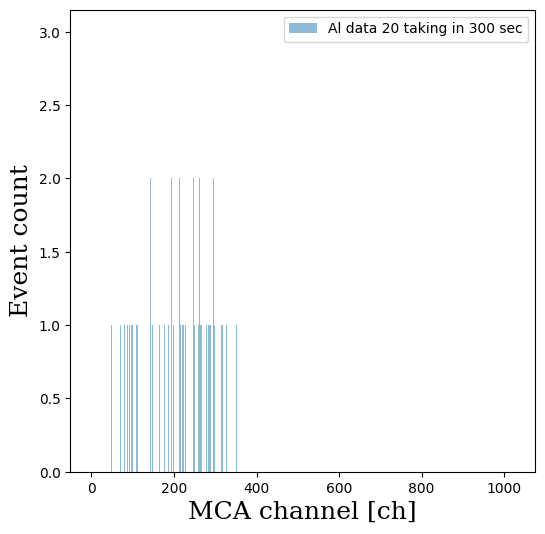

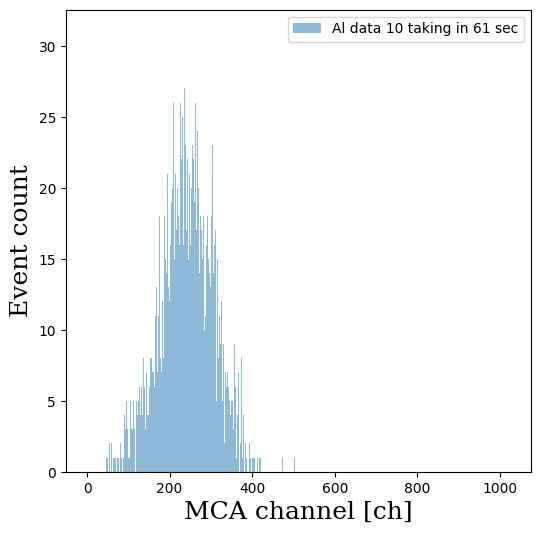

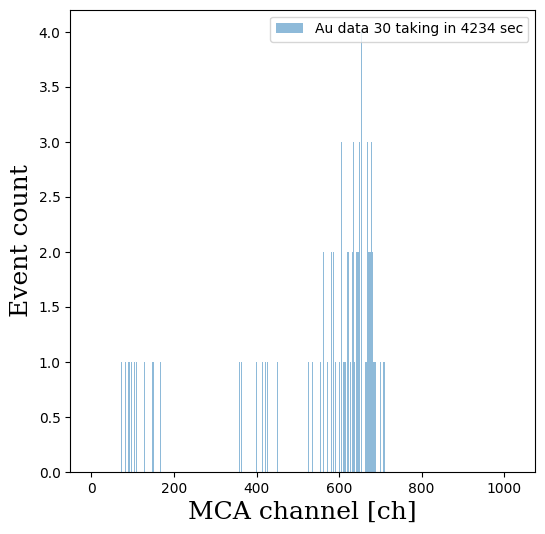

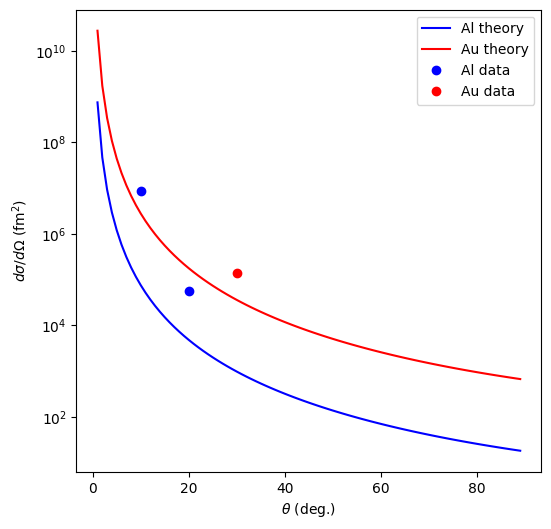

In [41]:
# @title 3.0.4. 観測結果読み込み
#散乱測定ファイル、ファイル名と測定角度を任意の回数入れる
Al_file_list=[]
Al_file_list.append(['300sec20degAl.csv',20])
Al_file_list.append(['60sec10degAl.csv',10])
Au_file_list=[]
Au_file_list.append(['Au_30.csv',30])


theta_Al=[]
dsdW_Al=[]
fig_list=[]
for file_i in Al_file_list :
  Al_file=np.genfromtxt(basePath+file_i[0], skip_footer=6)
  theta_Al.append(file_i[1])
  Nsig=np.sum(Al_file)
  tmes=pathToTime(basePath+file_i[0])
  dsdW_Al.append(Nsig/(B*tmes*NAl*1e-26*dOmega_TtoS))
  print("測定数　{:.2f} 測定時間{:.2f}".format(Nsig,tmes))

  fig_i = plt.figure(figsize=(6, 6))
  fig_list=np.append(fig_list,fig_i)
  ax = fig_list[-1].add_subplot(111)
  _ = ax.hist(x, bins=1024, weights=Al_file, range=(0, 1024), alpha=0.5, label='Al data {:.0f} taking in {:.0f} sec'.format(file_i[1],tmes))
  plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
  plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
  plt.legend(loc='upper right')


theta_Au=[]
dsdW_Au=[]
for file_i in Au_file_list :
  Au_file=np.genfromtxt(basePath+file_i[0], skip_footer=6)
  theta_Au.append(file_i[1])
  Nsig=np.sum(Au_file)
  tmes=pathToTime(basePath+file_i[0])
  dsdW_Au.append(Nsig/(B*tmes*NAu*1e-26*dOmega_TtoS))
  print("測定数　{:.2f} 測定時間{:.2f}".format(Nsig,tmes))

  fig_i = plt.figure(figsize=(6, 6))
  fig_list=np.append(fig_list,fig_i)
  ax = fig_list[-1].add_subplot(111)
  _ = ax.hist(x, bins=1024, weights=Au_file, range=(0, 1024), alpha=0.5, label='Au data {:.0f} taking in {:.0f} sec'.format(file_i[1],tmes))
  plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
  plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
  plt.legend(loc='upper right')

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
theta_x=np.arange(1,90)#プロットするx軸のbinを設定
fAl=AAl*(np.sin(np.radians(theta_x)/2))**-4
fAu=AAu*(np.sin(np.radians(theta_x)/2))**-4
ax.plot(theta_x, fAl, 'b-',label='Al theory')
ax.plot(theta_x, fAu, 'r-',label='Au theory')
plt.yscale('log')  # ログスケール
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel(r'$d\sigma/d\Omega$ (fm$^2$)')
plt.errorbar(theta_Al,dsdW_Al,fmt="o",color="b",label='Al data')#測定値Al
plt.errorbar(theta_Au,dsdW_Au,fmt="o",color="r",label='Au data')#測定値Au
plt.legend(loc='upper right')

# 3.1. 背景事象推定

有意性の推定を行うためには、背景事象の推定と誤差の見積もりが不可欠です。まずは背景事象の推定を行います。

今回の実験では、背景事象としては次のようなものが考えられます

1.   線源とは無関係な自然放射線の入射
2.   薄膜を通過せずに直接センサーへ入射する粒子
3.   薄膜以外の位置で散乱されてセンサーに入射する粒子

式からもわかるように、背景事象をいかに減らせるか、背景事象を信号事象からどれだけ正確に取り除けるか、そのうえで信号事象をいかに稼げるかが課題となります。

1.に関しては、先行実験で線源のない状態でt=4515秒の測定を行い$N_{obs}$=1イベントが観測されました。統計数が少ないためポアソン分布
$$
P(N|\lambda, t)=\frac{e^{-\lambda t}(\lambda t)^N}{N!}
$$
を仮定します。ここでは１度しか計測していないので、λに関して保守的な見積もりをします。具体的には、観測数が$N_{obs}$かそれ以下である確率が5%となるような最大のλを採用します。

$$
\Sigma_{N=0}^{N_{obs}}P(N|\lambda, t)=0.05
$$

3.1.1.を実行して、$\lambda$を求めましょう。より長時間の測定を行えば、保守的な推測でも$\lambda$の値は小さくなります。

In [15]:
# @title 3.1.1. 自然放射線量の推定
def N_to_lambda(N,p):
    bnds=((N,N),(0,None))
    func=lambda x: (poisson.cdf(x[0],x[1])-p)**2
    res=minimize(func,(N,N*2),bounds=bnds)
    for i in range(0,N+1):
      print("{:2d} {:.2e}".format(i,100*poisson.pmf(i,res.x[1])))
    return res.x[1]

Nobs=1
t=4515
lamb=N_to_lambda(Nobs,0.05)
print("推定されたlambda*t={:.2f}->lambda={:.2e}".format(lamb,lamb/t))
print("推定された背景事象数={:.2e}".format(lamb*tmes/t))


 0 8.72e-01
 1 4.13e+00
推定されたlambda*t=4.74->lambda=1.05e-03
推定された背景事象数=3.15e-01


2.及び3.の背景事象に関しては、ターゲット前後に障壁を作り信号事象を除去することで直接測定が可能です。背景事象の信号の形は実験セットアップにより大きく異なります。測定を行ったら、まずは3.1.2.で分布を比較しましょう。

2701secで測定した背景事象数9.00e+00 -> 4234secに予想される大まかな信号に混じる推定背景事象数1.41e+01


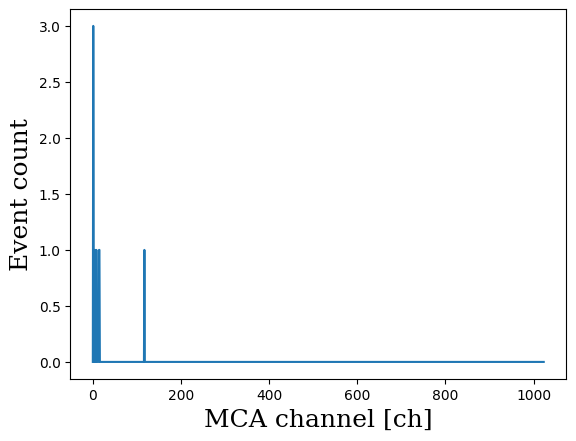

In [25]:
# @title 3.1.2. 線源由来背景事象の測定
#背景事象測定ファイル、適宜書き換えること
BG_file='dummyBG.csv'

bg = np.genfromtxt(basePath+BG_file, skip_footer=6)
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
plt.plot(x, bg)#背景事象
Nbg=np.sum(bg)#背景事象測定で得られたイベント数を全て足す
Tbg=pathToTime(basePath+BG_file)#sec, 背景事象の測定時間に書き換える
print("{:.0f}secで測定した背景事象数{:.2e} -> {:.0f}secに予想される大まかな信号に混じる推定背景事象数{:.2e}".format(Tbg,Nbg,tmes,Nbg/Tbg*tmes))

分布の重なり具合に応じて状況に応じた評価が必要です。
- チャンネルを制限すれば信号数を減らさずに背景事象数が減らせるのであれば、事象をカウントするチャンネル数を制限しましょう。
- 分布は重なってしまっているが、形が異なる場合(exponentialなど)の場合は、背景事象+信号事象の関数でフィッティングすることで信号事象のみ抽出することができます。
- 分布が重なってしまっており、かつ形も同じ場合は、直接的な推定は困難です。統計数を稼ぐなどの工夫が必要です。
- 背景事象数が十分少ないのであれば、3.1.1.と同様の手法で推定しても良いでしょう。

3.1.3.では、ダミーのデータを用いた仮の推定を行っています。測定されたデータに応じて書き換えやセルの追加をして実行してください。

In [ ]:
# @title 3.1.3. 線源由来背景事象の測定
x=np.arange(1,1025)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
_ = ax.hist(x, bins=1024, weights=bgPlot, range=(0, 1024), label='data')#背景事象のヒストグラムを作成
fig2 = plt.figure(figsize=(6, 4))
ax2 = fig2.add_subplot(111)
_ = ax2.hist(x, bins=1024, weights=sigPlot, range=(0, 1024), label='data')#信号事象のヒストグラムを作成

#フィット範囲定義,要調整
peakMin=50
peakMax=400
#背景事象のピーク成分をフィット
xpeak=x[(peakMin<x)&(x<peakMax)]
ypeak=bgPlot[(peakMin<x)&(x<peakMax)]
dypeak=np.where(ypeak > 0, np.sqrt(ypeak), 1.0)
parBGpeak,covBGpeak= curve_fit(sig, xpeak, ypeak, p0=(3, 200, 100), sigma=dypeak)
perrBGpeak = np.sqrt(np.diag(covBGpeak))
mat = np.vstack((parBGpeak,perrBGpeak)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *parBGpeak)
_ = ax.plot(x, y, 'r-', label='fitBGpeak')
#背景事象のexp成分をフィット
xexp=x[x<peakMin]
yexp=bgPlot[x<peakMin]
dyexp=np.where(yexp > 0, np.sqrt(yexp), 1.0)
parBGexp,covBGexp= curve_fit(bg, xexp, yexp, p0=(3, 50), sigma=dyexp)
perrBGexp = np.sqrt(np.diag(covBGexp))
mat = np.vstack((parBGexp,perrBGexp)).T
df = pd.DataFrame(mat,index=("Constant", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = bg(x, *parBGexp)
_ = ax.plot(x, y, 'b-', label='fitBGexp')
#背景事象全体をフィット
dy=np.where(bgPlot > 0, np.sqrt(bgPlot), 1.0)
parBG,covBG= curve_fit(bgFull, x, y, p0=(parBGpeak[0],parBGpeak[1],parBGpeak[2],parBGexp[0],parBGexp[1]), sigma=dy)#上記フィットで得られた値を初期値として使う
perrBG = np.sqrt(np.diag(covBG))
mat = np.vstack((parBG,perrBG)).T
df = pd.DataFrame(mat,index=("ConstantGaus", "Mean", "SigmaGaus","ConstantExp","SigmaExp"), columns=("Estimate", "Std. error"))
print(df)
y = bgFull(x, *parBG)
_ = ax.plot(x, y, 'g-', label='fitBG')

#信号事象のピーク成分をフィット
xpeak=x[(peakMin<x)&(x<peakMax)]
ypeak=sigPlot[(peakMin<x)&(x<peakMax)]
dypeak=np.where(ypeak > 0, np.sqrt(ypeak), 1.0)
parSIGpeak,covSIGpeak= curve_fit(sig, xpeak, ypeak, p0=(3, 200, 100), sigma=dypeak)
perrSIGpeak = np.sqrt(np.diag(covSIGpeak))
mat = np.vstack((parSIGpeak,perrSIGpeak)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *parSIGpeak)
_ = ax2.plot(x, y, 'r-', label='fitSIGpeak')

#背景事象の"形"と信号事象のピーク成分を合わせてフィット
dy=np.where(sigPlot > 0, np.sqrt(sigPlot), 1.0)
init=(tmes/Tbg,parSIGpeak[0],parSIGpeak[1],parSIGpeak[2])#背景事象のスケーリングは測定時間比を初期値とする。そのほかは上記ふぃとで得られた値を初期値とする。
parSIG,covSIG= curve_fit(lambda x,scale,a2,b2,c2: sigFull(x,parBG[0],parBG[1],parBG[2],parBG[3],parBG[4],scale,a2,b2,c2), x, y, p0=init, sigma=dy)#bgFullのフィットで得られた値は固定値として、その他の値をフィッティングする
perrSIG = np.sqrt(np.diag(covSIG))
mat = np.vstack((parSIG,perrSIG)).T
df = pd.DataFrame(mat,index=("ConstantBG","ConstantSIG", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
par = np.concatenate([parBG,parSIG],0)
y = sigFull(x, *par)
_ = ax2.plot(x, y, 'b-', label='fitBG')

#感度推定
peakMin=parSIG[2]-3*parSIG[3]#ピーク位置から+-3σ分だけカウント=信号事象の99.7%
peakMax=parSIG[2]+3*parSIG[3]
n=np.sum(sigPlot[(peakMin<x)&(x<peakMax)])
dn=np.sqrt(n)
print("from {:.2f} to {:.2f}".format(peakMin,peakMax))
parBG[0]*=parSIG[0]#背景事象の定数項をフィッティング結果に合わせてスケーリング
b,db=integrate.quad(lambda x: bgFull(x, *parBG), peakMin, peakMax)#スケーリングした関数をカウント範囲で積分
print("背景事象数 {:.2e} +/- {:.2e}".format(b,db))
sigma=np.sqrt(dn**2+db**2+b)#全測定事象の統計誤差、背景事象の推定誤差、背景事象の統計誤差を考慮
print("背景事象数 {:.2f} +/- {:.2f} と推測されるとき、{:.1f}回より大きく予想が外れる確率{:.2f}σ={:.2e}%".format(b,sigma,n,significance(n,b,sigma),prob(significance(n,b,sigma))*100))

# 3.2. 誤差推定

これまでは各種測定事象数に依存する統計誤差とその伝搬のみを誤差として取り扱ってきました。しかし、実際には測定装置や測定手法に依存する誤差も考慮する必要があります。背景事象の推定においては、推定手法に依存した誤差がないか検討しましょう。

信号事象においては、理論的な推定数に対し実際に観測された事象数に大きな乖離が見られたのではないでしょうか。これに関しても、誤差を議論することで理解することができます。3.2.1.をヒントとして用いて、誤差の原因について議論しましょう。

In [48]:
# @title 3.2.1. 角度議論用ツール
L1=58.3#mm
L2=11.7#mm
L3=60#mm
flag=1
alpha=-1*flag#cos(agnle) on target
beta=1*flag#cos(angle) on sensor
gamma=1*flag#cos(angle) on radiation source
ds1=3#mm, window size behind the target
ds2=3#mm, window size behind the sensor
dsi=5#mm, window size of radiation source

#theta_orig=theta
theta_orig=15
theta_orig=np.radians(theta_orig)

vL12=np.array([0,0,L1+L2])
vdL12=np.array([alpha*np.cos(np.pi/6),0,alpha*np.sin(np.pi/6)])
vdL12*=ds1*(L1+L2)/L1
vdLi=np.array([dsi*gamma,0,0])
vLI=vL12+vdL12-vdLi

vL3=np.array([-L3*np.sin(theta_orig),0,L3*np.cos(theta_orig)])
vdL3=np.array([ds2*beta*np.sin(theta_orig),0,ds2*beta*np.cos(theta_orig)])
vLO=vL3+vdL3-vdL12
print("流入ベクトル角度{:.3f} 散乱ベクトル角度{:.3f} 散乱しない粒子の流入が可能か{:b}".format(np.degrees(np.arctan(vLI[0]/vLI[2])),np.degrees(np.arctan(vLO[0]/vLO[2])),np.degrees(np.arctan(vLI[0]/vLI[2]))<np.degrees(np.arctan(vLO[0]/vLO[2]))))

thetap=np.arccos(np.dot(vLI,vLO)/np.sqrt(np.dot(vLI,vLI)*np.dot(vLO,vLO)))
print("最大ずれ角度{:.3f}".format(np.degrees(thetap)))

流入ベクトル角度-6.789 散乱ベクトル角度-10.518 散乱しない粒子の流入が可能か0
最大ずれ角度3.729
